<h1><b>DSC 170: Lecture 4. Advanced Operations and Spatial Data Structures (Geopandas - 3) </b></h1>

This lecture will cover:

- Set-operations with overlay  
    - We will see a common research scenario that relies on difference overlay and spatial join
- Examining valid and invalid geometries  
    - Some operations require valid geometries, and Geopandas provides a simple validity check  
    - What is an invalid geometry? It violates some properties, eg non-intersection of boundaries of a polygon
- Spatial data structures  
    - There are several vector data structures, with different levels of complexity and compactness  
    - They may provide integrity constraints to validate geometric objects  
    - Need to understand topological rules
- Accuracy of spatial data, and metadata standards  
    - There are 5 components of data quality report, as part of spatial metadata
- Geocoding  
    - Different geocoding providersaccessed via GeoPy may produce different results
    - Might use them in sequence

Please follow links embedded in the lecture - especially the slideshare one




## Overlay in Geopandas

Overlays are a common operation in GIS and spatial analysis, and are useful for tasks such as finding the common area shared by multiple features, combining features to create a new, more complex object, or identifying the areas where two or more features differ. They can be performed using the overlay function in Geopandas.

Overlay operations will create a new GeoDataFrame based on spatial overlap between objects in two input GeoDataFrames. Properties from both input GDFs are retained in the resultant GDF.

**Key difference compared with spatial join: spatial join doesn't create new features, it only attaches attributes from one GDF to another GDF where records are matched based on a spatial relationship. Overlay creates a set of new spatial features.**


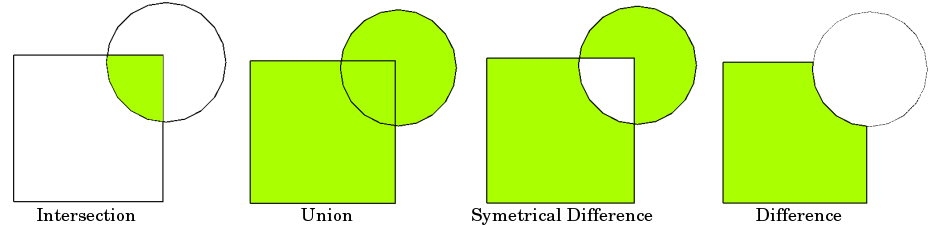

Let's explore it.

**Import geopandas, set data location, import overlay**

In [ ]:
%matplotlib inline 

import os
os.environ['USE_PYGEOS'] = '0'

import geopandas 
import pandas as pd

import os
current_dir = os.getcwd()
print(current_dir)
geopandas.__version__


In [ ]:
# set data location (uncomment one of them)
data_location = os.environ["HOME"]+"/public/datasets/"  # in the shared datahub 
# data_location = "../../8. Data/"    # on my local install

In [ ]:
from geopandas.tools import overlay

### Preparing data frames for overlay

In this example, we will find areas around observation decks within parks:
- construct a geodataframe with observation decks as points
- map both geodataframes, make sure they are in the same coordinate system
- create distance buffers around observation decks
- exclude observation deck buffers from park areas, using overlay

In [ ]:
# Let's continue our experimentation with SD Parks, and locations in or near parks 

shpFileIn = data_location +'sandiego/parks/PARKS.shp'
sd_parks = geopandas.read_file(shpFileIn)


In [ ]:
from shapely.geometry import Point
df = pd.DataFrame(
    {'Proposed observation decks': ['Location 1', 'Location 2', 'Location 3', 'Location 4'],
     'Latitude': [32.9, 33.0, 33.25, 33.4],
     'Longitude': [-116.25,-116.35, -116.00, -116.50]})

In [ ]:
# once we have a dataframe, let's construct geometry, declare it as a geometry column
# then define a CRS, and a CRS to project to

df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
new_locations = geopandas.GeoDataFrame(df, geometry='Coordinates')
new_locations.crs = 'epsg:4326'
new_locations_2230 = new_locations.to_crs('epsg:2230')


In [ ]:
# and then map both the parks and the new layer of observation decks

new_map = sd_parks.plot(figsize=(10,10), column = 'OWNERSHIP', legend = False)
new_locations_2230.plot(ax=new_map, legend = True,marker='o', color='black', markersize=100)

In [ ]:
# let's say, area around observation decks should be managed differently than the rest of the parks. 
# We need to exclude it from the parks, and estimate the remaining area 

new_locations_buffer = new_locations_2230.buffer(15000)
map1 = sd_parks.plot(figsize=(10,10), color='red')
new_locations_buffer.plot(ax=map1, color='black')

# Notice the 4 big black circles: these are 15000 feet buffers around our points (observation decks)

In [ ]:
# let's try polygon overlay with "difference"

parks_with_holes = geopandas.overlay(sd_parks, new_locations_buffer, how='difference')


### Why do we get an error?

In [ ]:
# overlay requires GeoDataFrames! Let's check if they are indeed GDFs:
# first, the sd_parks: 
type(sd_parks)

In [ ]:
# then, the new_locations:
type(new_locations_buffer)

In [ ]:
# The buffer operation generated a GeoSeries!

# Creating a GDF from a GeoSeries:

new_locations_buffer_gdf = geopandas.GeoDataFrame(new_locations_buffer, geometry=new_locations_buffer)


In [ ]:
# let's try it again:

parks_with_holes = geopandas.overlay(sd_parks, new_locations_buffer_gdf, how='difference')


In [ ]:
parks_with_holes.head()

In [ ]:
# and now, create a "difference" map

m2 = parks_with_holes.plot(figsize=(10,10))
new_locations_2230.plot(ax=m2, marker='o', color='red', markersize=50)

In [ ]:
# How would you do this if you just need geometries of 15000 buffers within parks? 

observed_parks = <your code here>
observed_parks.plot()

### This approach is used in many scenarios. 

For example, you want to find areas that are further away from major hospitals, and then identify which income and ethnic groups are relatively underserved within the county (based on lower accessibility to hospitals). 

You have hospital locations as a gdf, and county polygon as another gdf. 
- The first step is to create buffers around the hospital points (say, 20-min drive, or 10-mile distance.) 
- Then you can compute the "difference" overlay: subtract these buffers from the "county" polygon. These are the underserved areas.
- Then you can do further analysis, e.g. identify census tracts or block groups or zip codes that are within the well-served areas, and within the underserved areas (HOW? Recall the previous lecture!). Retrieve ethnic and income indicators for both types of areas, and figure out if the differences are significant.

That approach was used in one of DSC170 final projects: https://drive.google.com/file/d/1mR4U26LTzhLKWmHEZ9eJgYK8IW6Fy1z8/view?usp=sharing

__Can you think of additional scenarios?__

## Valid and invalid geometries

Recall what we did in the earlier notebooks using Geopandas. One of the requests was to find adjacent parks (or counties, or other objects that should have shared boundaries). Geopandas could not establish topological adjacency: 

```python
adjacent = sd_parks_dis.touches(sd_parks_dis.shift())
```

failed, but returned some intersections: 
```python
intersect = sd_parks_dis.intersects(sd_parks_dis.shift()) 
```
Is this a good result? How accurate do we expect the boundaries to be? Is the accuracy known, at least for government spatial data? It's complicated, and approaches to describing accuracy have evolved. For example, positional accuracy in map production: from National Map Accuracy Standard (eg "90% of well-defined points within .02”, with map producers responsible for making an accurate map), to standards where data producers should report elements of data quality (as completely as possible) and users are responsible for evaluating fitness for purpose. We'll cover that in more detail later, but first will talk about __geometric validity__. 

A **valid geometry** is a geometric object (such as a point, line, or polygon) that satisfies the rules of geometric construction and topological relationships.

For example:

    - A line must have at least two coordinate pairs and must not self-intersect (*)
    - A polygon must have at least three coordinate pairs and must not have self-intersections or holes. The first and last coordinate pairs must also be the same, indicating that the polygon is closed.
    - A multi-part geometry (such as a multi-point, multi-line, or multi-polygon) must have at least one part and must not have any overlapping or intersecting parts.


<i>(*) This is merely an example of a rule, often enforced in ArcGIS for specific applications. There are also tools to find and repair self-intersecting lines. But self-intersecting lines are perfectly fine from the perspetive of the OGC Simple Features spec. In the OGC "Simple Features" spec (and in Geopandas), point or line geometries cannot be invalid. 

Further into the woods: a self-intersecting line is an example of a non-simple feature. Geopandas doesn't distinguish between simple and non-simple features.
</i>

Some examples of errors: https://www.gislounge.com/gis-data-a-look-at-accuracy-precision-and-types-of-errors/. In Geopandas, we can check for geometric validity (basically, if it complies with OGC simple features); if not some operations would fail (eg dissolve):

```python
GeoSeries.is_valid
Returns a Series of dtype('bool') with value True for geometries that are valid.
```

Uncertainty is inherent in location measurement (more about it later in this lecture). But at least we can try to make the geometries valid. 

### Experiment with polygons at http://geojson.io
We'll create a couple polygons that are a bit more complex than what you saw earlier. And then see if they have valid geometry. Note that you can save geojson and topojson. 

In [ ]:
# Let's draw a few moderately compex polygons in GeoJSON.io, and paste the fragments below
gjson = '''
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -117.14429336903922,
            35.24667991988589
          ],
          [
            -115.77095699973015,
            35.7454018687754
          ],
          [
            -115.45479323125615,
            34.85034412807504
          ],
          [
            -117.13441325127432,
            34.85845182176223
          ]
        ],
        "type": "LineString"
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -114.47666157253948,
            35.67319897431048
          ],
          [
            -112.67848013934334,
            35.889611307010725
          ],
          [
            -112.89584273016912,
            34.566072106045425
          ],
          [
            -114.0419363908875,
            35.99359954893734
          ],
          [
            -114.25929898171368,
            35.448149912404844
          ],
          [
            -112.44135731298773,
            35.49642789644956
          ]
        ],
        "type": "LineString"
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -114.73354463442448,
              34.02736629925879
            ],
            [
              -114.67426392783587,
              33.2624452989284
            ],
            [
              -112.67848013934334,
              33.295484762328954
            ],
            [
              -114.0221761553581,
              34.411344433601556
            ],
            [
              -114.73354463442448,
              34.02736629925879
            ]
          ]
        ],
        "type": "Polygon"
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -111.93747130698225,
            34.74487143532426
          ],
          [
            -110.59377529096749,
            35.068971150309636
          ],
          [
            -110.1590501093155,
            34.15010259304455
          ],
          [
            -111.55214671415438,
            35.109393588780236
          ],
          [
            -110.31713199355269,
            34.7611067846083
          ],
          [
            -111.36442447662289,
            33.86344141180312
          ],
          [
            -112.07579295568965,
            34.574207713064254
          ]
        ],
        "type": "LineString"
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -111.06802094367866,
              36.264921108602636
            ],
            [
              -109.16115821506942,
              35.94562197833352
            ],
            [
              -111.63118765627277,
              35.905618402839366
            ],
            [
              -110.69257646861568,
              35.625027387616825
            ],
            [
              -110.17881034484529,
              36.57498604251708
            ],
            [
              -109.4970822190732,
              35.67319897431048
            ],
            [
              -109.52672257236752,
              36.47176864660999
            ],
            [
              -111.06802094367866,
              36.264921108602636
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}'''


In [ ]:
# Notice that geojson.io doesn't handle complex polys well.

myfeatures = geopandas.read_file(gjson)

print(len(myfeatures))
# myfeatures = geopandas.read_file(tjson)
for i in range(len(myfeatures)):
    print(myfeatures.loc[i,'geometry'].is_valid)

myfeatures.plot()


### Polygon representation (OGC Simple Features)

The OGC Simple Features spec supports polygons that can have multiple part, holes, islands. This is done by describing polygons as bounded by linear rings with different direction of vertices: one clockwise exterior ring, and zero or more counterclockwise interior rings describing holes.

```python
Help on Polygon in module shapely.geometry.polygon object:
     class Polygon(shapely.geometry.base.BaseGeometry)
      |  A two-dimensional figure bounded by a linear ring
      |
      |  A polygon has a non-zero area. It may have one or more negative-space
      |  "holes" which are also bounded by linear rings. If any rings cross each
      |  other, the feature is invalid and operations on it may fail.
      |
      |  Attributes
      |  ----------
      |  exterior : LinearRing
      |      The ring which bounds the positive space of the polygon.
      |  interiors : sequence
      |      A sequence of rings which bound all existing holes.
    
```
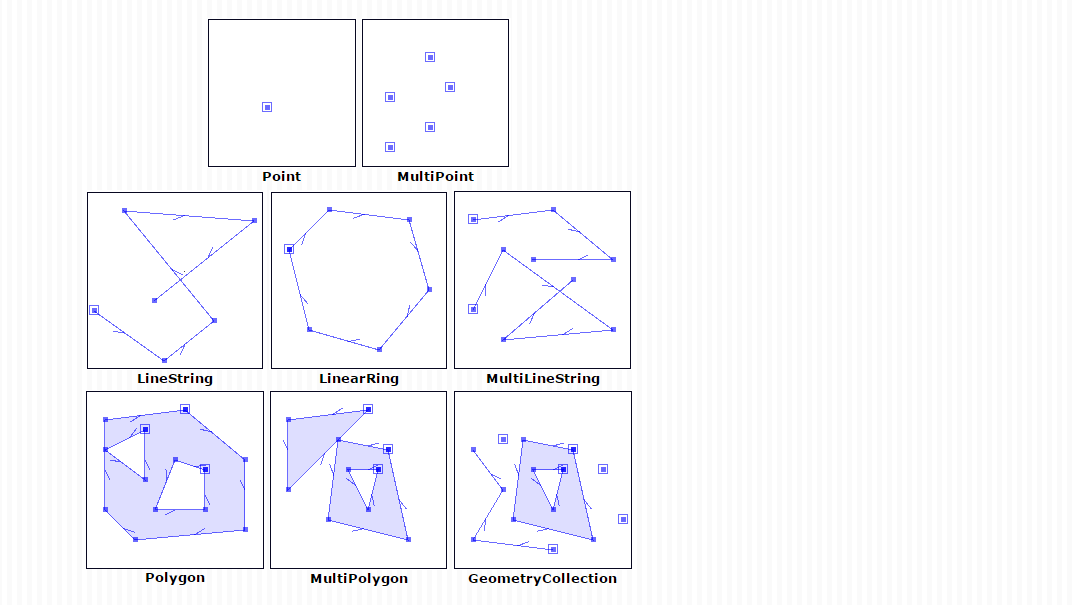



In some applications geometric accuracy is very important! 
For example, parcel management: if non-zero intersection between adjacent parcels, you end up in court! 

But how do you ensure that geometries are correct? Need to specify rules for geometric correctness based on topological relationships --> topological data structures. 


## Elementary Spatial Data Structures: introduction 

Spatial data structures are techniques used to store and organize spatial data in a way that is efficient and suitable for spatial analysis and mapping. 


### Vector and Raster - two main types
* Representation of geographic information:
    * **Raster**: location controlled, attribute measured
        * values are stored in ordered array, so that  position in the array defines geographic location
        * often from imagery sources, not good for lines and objects smaller than resolution (think of 0-D objects, now they have areas? Better for larger areas)
        * well-suited for representing continuous data, such as elevation or land cover.
    * **Vector**: attribute controlled, location measured
        * used to store and represent spatial data as discrete geometric objects, such as points, lines, or polygons.
        * geographic coordinates are typically stored separately from attributes, connected with identifiers
        * well-suited for representing discrete data, such as land parcels or transportation networks
    * Trade-offs: 
    
        - "Yes, raster is faster but raster is vaster 
        - And vector just seems more corrector"
        
    * Is this still an issue? YES - because they represent different types of measurement with different statistical properties. Often need both.
        
        
Also, there are **object-based** data structures: used to store and represent spatial data as a set of discrete objects, each with its own set of attributes. Used in object-oriented GIS.
        
### Vector data structures, historically:
* trends: 
    * increasing complexity, refining logic; 
    * making geographic relationships EXPLICIT
* Spaghetti files (1974...)
    * the original CIA format
    * lines and points which the reader must organize
    * "spaghetty and meatballs" is an extension (with label points)
* Polygon loops (location lists):
    * polygons stored as objects, polygon shading is easy, IF CORRECT!
    * problems: common line defined twice; slivers between adjacent polygons because boundaries not necessarily the same
* Point dictionary
    * polygon descriptions refer to lists of fixed points with coordinates (point dictionaries)
    * similar to polygon loops, but instead of coordinates of vertices in polygon descriptions - IDs of vertices
* Topological data structure
    * Implemented in Census Bureau's DIME (Dual Independent Map Encoding) and later TIGER (Topologically Integrated Geographic Encoding and Referencing) files; used as the basis for geoprocessing in Odyssey GIS, which became the template for many modern GIS (https://en.wikipedia.org/wiki/Harvard_Laboratory_for_Computer_Graphics_and_Spatial_Analysis); 
    * Organizes Points, Lines, and Areas as Nodes, Chains, and Polygons
    * The model: nodes bound chains, chains co-bound polygons; chains co-bound nodes, polygons co-bound chains...
    * the structure stores topological relationships between nodes, chains, and polygons; these relationships are used in defining chains through nodes, polygons through chains, etc. 
    * Provides for contiguity, better quality control. Another major purpose: enables powerful spatial analysis (eg adjacency is just a lookup)
(see https://slideplayer.com/slide/4737156/ - these are from my old lectures! see slides 15 and on, can skip 18-19). A simplified algorithm for building topology from GeoJSON geometries is described in https://bost.ocks.org/mike/topology/

### Geometric Errors, Topologically Identifiable on a single layer
* forgotten nodes
* missing polygon label points
* overshoots
* undershoots
* duplicate arcs
* two or more label points in one polygon
* two nodes do not match
* knots (unintentional line crossings)
* missing lines
* wild (extra) lines

### Multi-layer quality control
For example:  
- points must be inside polygons, or on lines from a different layer (e.g., gauge stations on streams)  
- polygons must not overlap (e.g., building footprints must be completely within parcel boundaries);  
- lines must not cross

Recent GIS software (eg ArcGIS) supports specific and granular topological rules. For example, imagine that you managing parcel information (property lots) and need to make sure that parcels are not in conflict with sidewalks, building footprints, zoning, etc. This may result in rules such as:  
- Lots must be valid (closed, without intesecting boundaries) polygons
- Building footprint must be  __within__ a lot
- Sidewalks must be outside (__disjoint__ or __touch__) lot polygons
- Lots must be __within__ a single zone on a zoning map
- Lots must __touch__ either another lot or city land (eg sidewalks).


## GeoJSON and TopoJSON

GeoJSON is an open standard format designed for representing simple geographical features, along with their non-spatial attributes.
"TopoJSON is an extension of GeoJSON that encodes topology. Rather than representing geometries discretely, geometries in TopoJSON files are stitched together from shared line segments called arcs. TopoJSON eliminates redundancy, offering much more compact representations of geometry than with GeoJSON; typical TopoJSON files are 80% smaller than their GeoJSON equivalents. In addition, TopoJSON facilitates applications that use topology, such as topology-preserving shape simplification, automatic map coloring, and cartograms." (from https://github.com/topojson/topojson/blob/master/README.md. Also see https://github.com/topojson/topojson/wiki) 

TopoJSON: 
* Smaller file size because doesn't store duplicate geometries 
* can encode multiple related geometries
* can use delta-endocing for integer coordinates --> smaller file size
* less potential for errors
* but: more expensive rendering and operations where feature geometries are treated independently



## Accuracy of spatial data

### Different frameworks for describing error

Error is difference between the true value, and measured or perceived value (is there a problem with this definition?)

* Communication model:
    * Error is difference between message received by map reader, and the “Real World” 
    * Why error? Encoding and decoding graphic message (depends on cartographer’s skills, and map reader’s skills)
        * Phil Gersmehl's classic paper "The data, the reader, and the innocent bystander - a parable for map users", 1985 (https://www.researchgate.net/publication/227688283_The_data_the_reader_and_the_innocent_bystander_-_a_parable_for_map_users): how from a coarse-resolution dot maps that showed the general distributions of soil orders in the 48 states it became a “Principal Peatlands of the United State" map in a planning document, through a series of misinterpretations 
* Analytical perspective:
    * Error is difference between measured quantity and its true value; distortion of relationships that should be invariant, etc. (But: What is reality?)
    * Why error? Measurement errors, technical limits, logical flaws...
* These perspectives may be contradictory: to communicate message one sometimes has to distort reality 


### Accuracy vs Precision
See  https://www.gislounge.com/gis-data-a-look-at-accuracy-precision-and-types-of-errors/, etc.



### Components of data quality report:
* __Lineage__ (provenance)  (the difference between the terms really is only in perspectives)
    * source material; operations performed; established control points (eg on the ground); coordinate transformations
* __Positional accuracy__
    * quality of any control surveys and transformations; assessed via repeated measurements, deductive estimates, cross-validation
    * sometimes distortions are planned:
        * ex-USSR
        * location obfuscation techniques (https://en.wikipedia.org/wiki/Location_obfuscation): random noise added to position, or rounding to landmarks, or removing location info ("a person is k-anonimous if her exact location cannot be distinguished among k-1 other people")
* __Attribute accuracy__
    * it is sometimes difficult to separate attribute and positional error (eg for categorical coverages). Assessment depends on scales of measurement; can be done via comparson with independent source, repeated measurement using additional devices, cross-validation, etc.
* __Logical consistency__
    * whether the data fits into an expected model (eg topological)
    * tests for outliers/blunders; typical suspect values (eg the (0,0) location)
* __Completeness__
    * how the data in the dataset were selected from the real world; any definitions used; are all defined categories present. Example criteria:
        * geometric criteria: roads down to 20’ wide?
        * definition: woodland means 20% tree cover?
        * rules: individual buildings outside built-up area?
                

### Accuracy information is part of metadata. Why is metadata important?

Metadata is information about the data: "What? Who? Why? When? Where? How? of your data"
Answers questions: 

* WHAT is the content of the data; WHAT sources were used
* WHO created the data and who is managing it
* WHERE is the data collected (study area); WHERE can it be accessed
* WHEN is the data collected (time period of the content); WHEN was the data created, processed, databased, etc..
* WHY was the data created (purpose, limitations, appropriate uses)
* HOW was it created, processed, distributed, what is the resultant data quality

No lack of information about spatial metadata, eg https://www.fgdc.gov/metadata/iso-suite-of-geospatial-metadata-standards

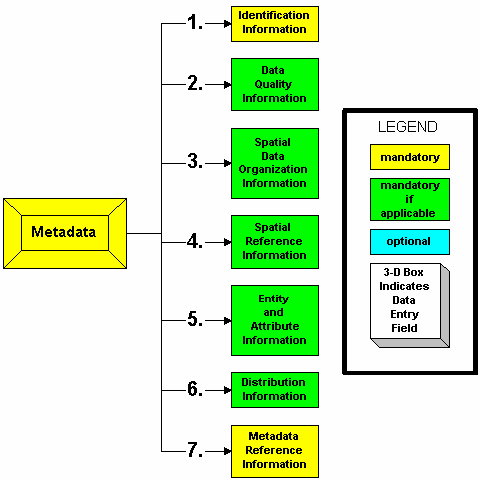
(From FGDC)

<b> Our recent project on generating metadata automatically: Data Discovery Studio, http://datadiscoverystudio.org. And a paper about it (https://onlinelibrary.wiley.com/doi/abs/10.1002/cpe.6086)  </b>

## Geocoding in geopandas 
(optional; we'll spend more time on this with ArcGIS)

Geocoding in geopandas is simple (need a geopy module installed), and the default geocoding (now based on Photon geocoder) getting increasingly powerful with every release. Performance, especially for complicated addresses, depends on a geocoding provider available through geopy. Some providers require an API key. When using free geocoders, follow fair usage etiquette (extensive usage will be throttled, most likely).

Geopy does geocoding, reverse geocoding, and distance between points, both geodesic (on ellipsoid) and great-circle  (on a sphere). See https://geopy.readthedocs.io/en/latest/ 

### Try different geocoders and compare results

In [ ]:
# this is how you install it if needed:
# !pip install --user geopy

In [ ]:
from geopandas.tools import geocode
import geopy
import geopandas as gpd
from shapely.geometry import Point

df = geocode(
    ['4164 Altadena Avenue, San Diego, CA', '3974 Bancroft Street, San Diego, CA', 'UCSD, La Jolla, CA'])
df.head()


In [ ]:
# Nominatim (from OpenStreetMap) is another popular free option:
df = geocode(
    ['4164 Altadena Avenue, San Diego, CA', '3974 Bancroft Street, San Diego, CA', 'UCSD, La Jolla, CA'], 
             provider = 'nominatim', user_agent="myself")

df.head()


In [ ]:
# Compare with ArcGIS geocoder results:
df = geocode(
    ['4164 Altadena Avenue, San Diego, CA', '3974 Bancroft Street, San Diego, CA', 'UCSD, La Jolla, CA'], 
             provider = 'ArcGIS')


In [ ]:
df.head()

# we'll do more geocoding in ArcGIS; there will be more options

### More about geocoding accuracy

In Google, location_type stores additional data about the specified location. The following values are currently supported:

"ROOFTOP" indicates that the returned result is a precise geocode for which we have location information accurate down to street address precision.

"RANGE_INTERPOLATED" indicates that the returned result reflects an approximation (usually on a road) interpolated between two precise points (such as intersections). Interpolated results are generally returned when rooftop geocodes are unavailable for a street address.

"GEOMETRIC_CENTER" indicates that the returned result is the geometric center of a result such as a polyline (for example, a street) or polygon (region)."

"APPROXIMATE" indicates that the returned result is approximate.

Example:
<code>
import googlemaps
</code>

 --- Define your API key (replace 'YOUR_API_KEY' with your actual Google API key)

<code>
api_key = 'YOUR_API_KEY'
</code>

 --- Initialize the Google Maps client with your API key

<code>
gmaps = googlemaps.Client(key=api_key)
</code>

--- Define an address for geocoding

<code>
address = "4164 Altadena Avenue, San Diego, CA"
</code>

--- Perform a geocoding request

<code>
geocode_result = gmaps.geocode(address)
</code>

--- Print the result (note the Location Type)

<code>
for result in geocode_result:
    print(f"Formatted Address: {result['formatted_address']}")
    print(f"Location Type: {result['geometry']['location_type']}")
    print(f"Coordinates: {result['geometry']['location']}")
    print("---")
</code>

In [ ]:
# Let's see what information is available from nominatim, a popular geocoder used by OpenStreetMap (OSM)
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myself")
location = geolocator.geocode("4164 Altadena Ave, San Diego, California, 92105")
print("Place ID from OpenStreetMap: "+ str(location.raw['place_id']))
print("Bounding box: " + str(location.raw['boundingbox']))

print("Latitude and Longitude :" + str(location.latitude) + "  "+str(location.longitude))
print(location.raw['lat'])

print("The entire content of location.raw")
print(location.raw)


Here, **'class': 'place', 'type': 'house'** points to a single interpolated housenumber (judging from 'osm_type': 'node').
Importance: is a computed score in [0...1] that helps select between several potential geocoding targets, similar to relevance score in Wikipedia. See more at https://github.com/osm-search/wikipedia-wikidata 


### See a working example of nominatim geocoder for early COVID-19 records from Johns Hopkins, in a [separate notebook](Geocode_nominatim.ipynb)

### Factors affecting geocoding accuracy: summary

    - Ambiguity of location descriptions, and multiple possible locations. 
    - Incomplete or incorrect location descriptions
    - Outdated or incorrect data, in particular street and POI data.
    - Diferences in location representation by different geocoding services or databases


